# Cabbeling experiments

This notebook contains plots from the cabbeling experiments.
The folder also contains animations of the density field, tracers, and density reference profile.

The saved data is broken up into:

- `tracers.nc`;
- `computed_output.nc`; and
- `energy_diagnostics.nc`.

`energy_diagnostics.nc` is computed in post processing.

In [1]:
cd("/g/data/e14/jb2381/CabbelingExperiments")
using Pkg
Pkg.activate(@__DIR__)

  Activating project at `/g/data/e14/jb2381/CabbelingExperiments`


In [4]:
using NCDatasets, CairoMakie, TwoLayerDirectNumericalShenanigans, StatsBase, Printf

In [5]:
computed_output = joinpath(pwd(), "outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/computed_output.nc")
tracers = joinpath(pwd(), "outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/tracers.nc")
velocities = joinpath(pwd(), "outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/velocities.nc")
energetics = joinpath(pwd(), "outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/energy_diagnostics.nc")

"/g/data/e14/jb2381/CabbelingExperiments/outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/energy_diagnostics.nc"

## Computed output

Output saved that was computed during simulation.

In [6]:
co_ds = NCDataset(computed_output)
t = co_ds[:time][:] ./ 60
find_num = findfirst('k', co_ds.attrib["Reference density"]) - 1
ρ₀ = parse(Float64, co_ds.attrib["Reference density"][1:find_num])
∫Eₖ = ρ₀ * co_ds[:∫Eₖ][:]
∫ϵ = co_ds[:∫ϵ][:]
∫κᵥ = co_ds[:∫κᵥ][:]
∫ₐκᵥ = co_ds[:∫ₐκᵥ][:, :]
σ = co_ds[:σ][:, :, :, 20]
x_length = length(co_ds[:xC])
y_length = length(co_ds[:yC])
z_grid = co_ds[:zC][:]
z = repeat(co_ds[:zC][:], inner= x_length * y_length)
dV = diff(co_ds[:xC][1:2]) .* diff(co_ds[:yC][1:2]) .* diff(co_ds[:zC][1:2])
close(co_ds)

closed Dataset

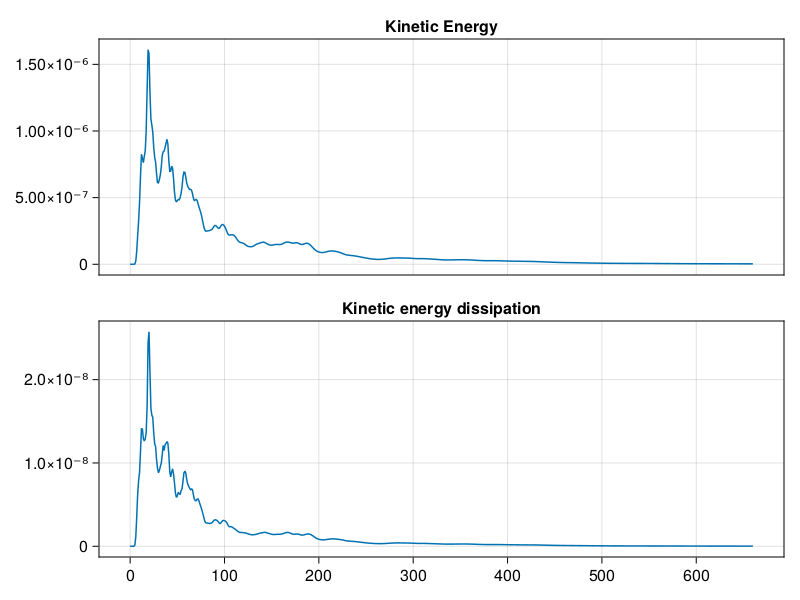

In [92]:
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1]) for i ∈ 1:2]
lines!(ax[1], t, ∫Eₖ)
ax[1].title = "Kinetic Energy"
lines!(ax[2], t, ρ₀ .* ∫ϵ)
ax[2].title = "Kinetic energy dissipation"
linkxaxes!(ax[1], ax[2])
hidexdecorations!(ax[1], grid = false)
fig

## Energetic computations

Some of these are done on the fly and some are done (or can be done to check) in post processing.

The kinetic energy and turbulent kinetic energy dissipation is computed on the fly using [Oceanostics.jl](https://github.com/tomchor/Oceanostics.jl).
The potential energy is computed on the fly using a `KernelFunctionOperation` I wrote into TwoLayerDirectNumericalShenanigans.
These quantites are all saved in `computed_output.nc`.
See ths plotted quantities above.

Post processing is done using `energetics_animations.jl` and saved in `energy_diagnostics.nc`.
This file contains a post processing calculation of potential energy as well as background potential energy (these can then be used to get the available potential energy).

I thought I saved the vertical buoyancy flux but will have to do this later as it is not there or did not work.

In [89]:
en_ds = NCDataset(energetics)
t = en_ds[:time][:] ./ 60
∫Eb = en_ds[:∫Eb][:] 
∫Ep = en_ds[:∫Ep][:]
∫ρw = en_ds[:∫ρw][:]
∫Eₖ_unscaled = en_ds[:∫Eₖ][:]
Φᵢ = en_ds[:Φᵢ][:]
close(en_ds)

closed Dataset

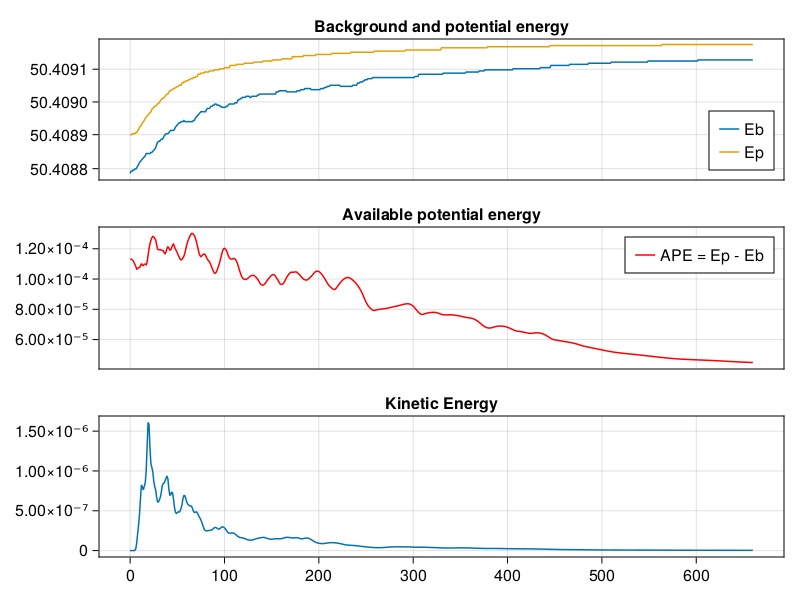

In [9]:
APE = ∫Ep .- ∫Eb
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1]) for i ∈ 1:3]
lines!(ax[1], t, ∫Eb, label = "Eb")
lines!(ax[1], t, ∫Ep, label = "Ep")
hidexdecorations!(ax[1], grid = false)
ax[1].title = "Background and potential energy"
axislegend(ax[1], position = :rb)
lines!(ax[2], t, APE, color = :red, label = "APE = Ep - Eb")
axislegend(ax[2])
hidexdecorations!(ax[2], grid = false)
ax[2].title = "Available potential energy"
lines!(ax[3], t, ∫Eₖ)
ax[3].title = "Kinetic Energy"
fig

The slope of the APE should be the diffusivity. In this case where diffusivity is not monotone I can calculate both a linear fit and a linear fit at each time step to give an average effective diffusivity and an instantaneous effective diffusivity.

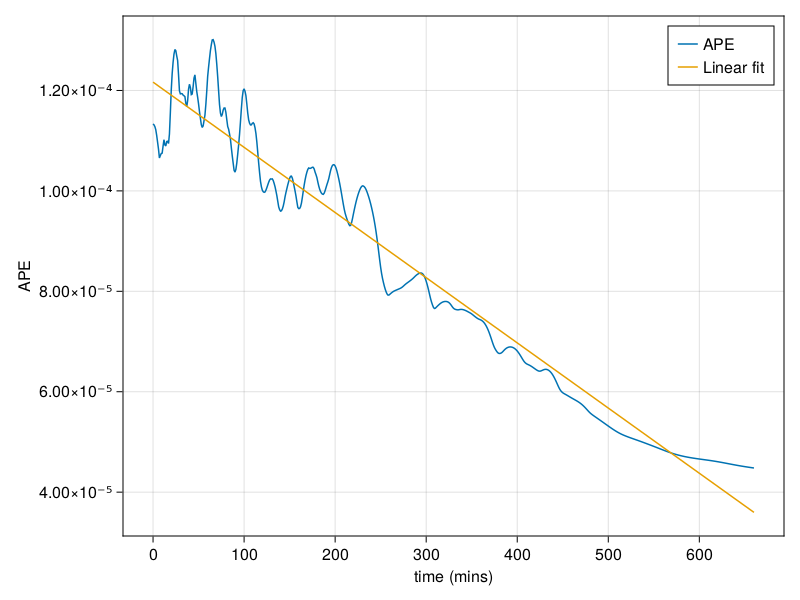

In [10]:
linear_fit = [ones(length(t)) t] \ APE
fig = Figure(size = (250, 500))
ax = Axis(fig[1, 1], xlabel = "time (mins)", ylabel = "APE")
lines!(ax, t, APE, label = "APE")
lines!(ax, t, linear_fit[1] .+ linear_fit[2] .* t, label = "Linear fit")
axislegend(ax)
fig

In [77]:
println("Slope is $(linear_fit[2])") # possible need to multiple be reference density?

Slope is -1.2982324291458254e-7


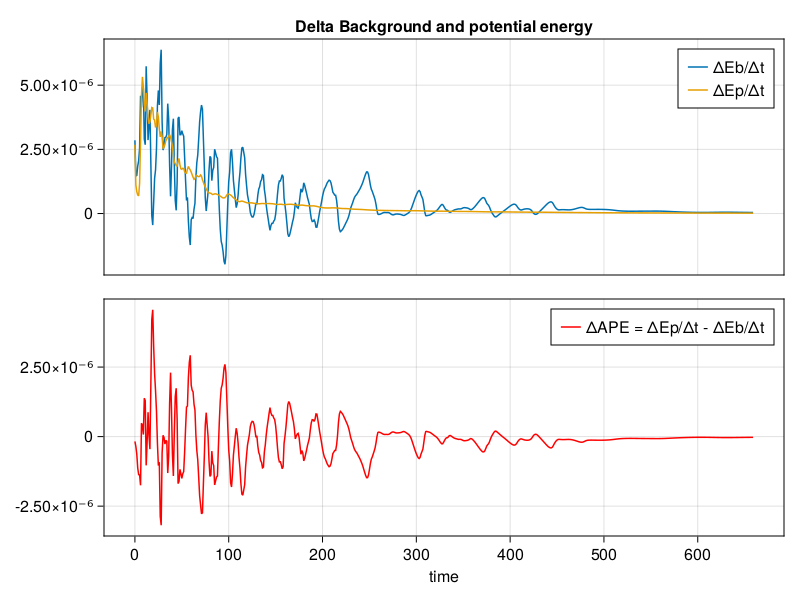

In [12]:
Δt = diff(t)
Δ∫Eb = diff(∫Eb) ./ Δt
Δ∫Ep = diff(∫Ep) ./ Δt
ΔAPE = Δ∫Ep .- Δ∫Eb
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "time") for i ∈ 1:2]
lines!(ax[1], t[1:end-1], Δ∫Eb, label = "ΔEb/Δt")
lines!(ax[1], t[1:end-1], Δ∫Ep, label = "ΔEp/Δt")
hidexdecorations!(ax[1], grid = false)
ax[1].title = "Delta Background and potential energy"
axislegend(ax[1])
lines!(ax[2], t[1:end-1], ΔAPE, color = :red, label = "ΔAPE = ΔEp/Δt - ΔEb/Δt")
axislegend(ax[2])
fig

Clearly increases and decreases in APE (not just decreasing) as is the case for isothermal experiment.
The production of dense water at the interface will change the background state, making it 

## Closing the energy budget

With the quantities I have I can close the energy budget to then make further calculations.
I compute $\int_{V}E_{k}\mathrm{d}V$ and $\int_{V}\epsilon\mathrm{d}V$ on the fly.
Then in post processing I compute the potential energy $E_{p} = \int_{V}g\rho z\mathrm{d}V$ and background energy $E_{b} = \int_{V}g\rho z_{*}\mathrm{d}V$ which can then be used to calculate the available potential energy $E_{a} = E_{p} - E_{b}$.

The two other terms I need are the buoyancy flux $\Phi_{z} = \int_{V}g\rho w\mathrm{d}V$ and the irreversible internal to potential energy conversion $\Phi_{i}$.
I have a post processing calculation of $\Phi_{z}$ but I can also approximate it from the kinetic energyy as $\int_{V}E_{k}\mathrm{d}V = -\Phi_{z} - \int_{V}\epsilon\mathrm{d}V$. I will compute $\Phi_{z} = \int_{V}E_{k}\mathrm{d}V + \int_{V}\epsilon\mathrm{d}V$ to check against my computation.
Finally $\Phi_{i} = E_{p} - \Phi_{z}$. I also have a computation of this which I will compare to.

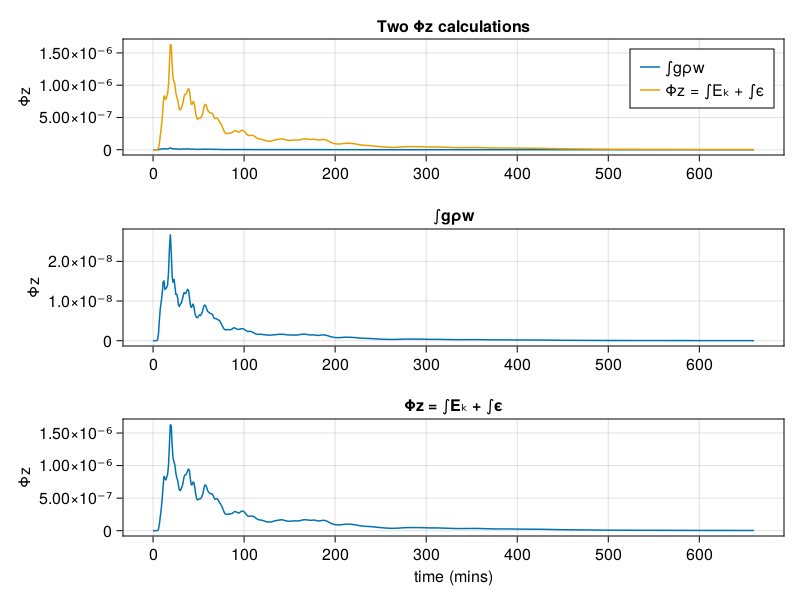

In [87]:
Φz = ρ₀ .* (∫Eₖ_unscaled .+ ∫ϵ)
fig = Figure(size = (500, 500))
ax = Axis(fig[1, 1], title = "Two Φz calculations", ylabel = "Φz")
lines!(ax, t, ∫ρw, label = "∫gρw")
lines!(ax, t, Φz, label = "Φz = ∫Eₖ + ∫ϵ")
axislegend(ax)
ax1 = Axis(fig[2, 1], title = "∫gρw", ylabel = "Φz")
lines!(ax1, t, ∫ρw)
ax2 = Axis(fig[3, 1], title = "Φz = ∫Eₖ + ∫ϵ", xlabel = "time (mins)", ylabel = "Φz")
lines!(ax2, t, Φz)
fig

The signal is the same (which is good!) but they are off by an order of magnitude.. I will have to trust $\Phi_{z} = \int_{V}E_{k}\mathrm{d}V + \int_{V}\epsilon\mathrm{d}V$ as these are the integrated quantites that are calculated on the fly. Also possible there is a bug somewhere in my post processing calculation.

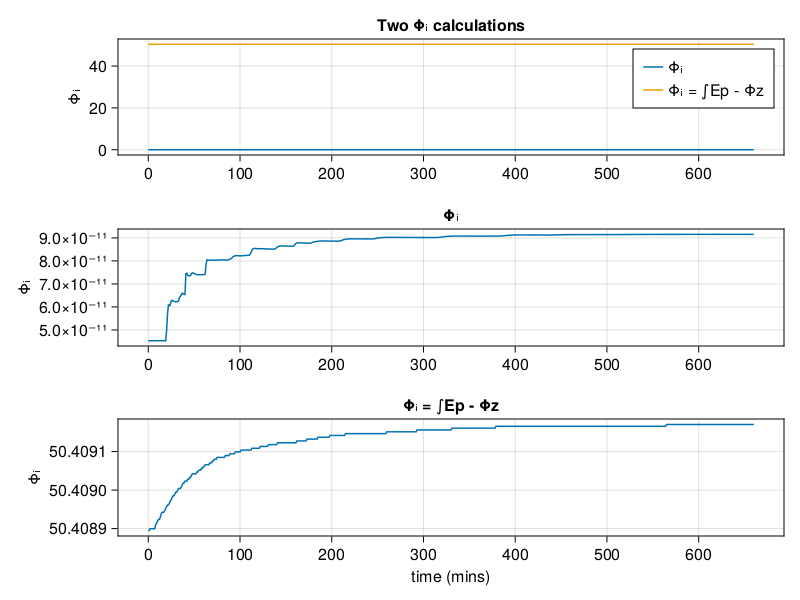

In [91]:
Φᵢ_post = ∫Ep .- Φz
fig = Figure(size = (500, 500))
ax = Axis(fig[1, 1], title = "Two Φᵢ calculations", ylabel = "Φᵢ")
lines!(ax, t, Φᵢ, label = "Φᵢ")
lines!(ax, t, Φᵢ_post, label = "Φᵢ = ∫Ep - Φz")
axislegend(ax)
ax1 = Axis(fig[2, 1], title = "Φᵢ", ylabel = "Φᵢ")
lines!(ax1, t, Φᵢ)
ax2 = Axis(fig[3, 1], title = "Φᵢ = ∫Ep - Φz", xlabel = "time (mins)", ylabel = "Φᵢ")
lines!(ax2, t, Φᵢ_post)
fig

This one is completely different though I think I have to throw out my computation. We do not have surface buoyancy flux so I think this is why it is incorrect.

## Rate of change 

Above many of my calculations are made with the *time series* of the volume integrated quantities.
Though looking at the formaulae it looks that they should be made with the rates of change so here I compute these to see if things add up.

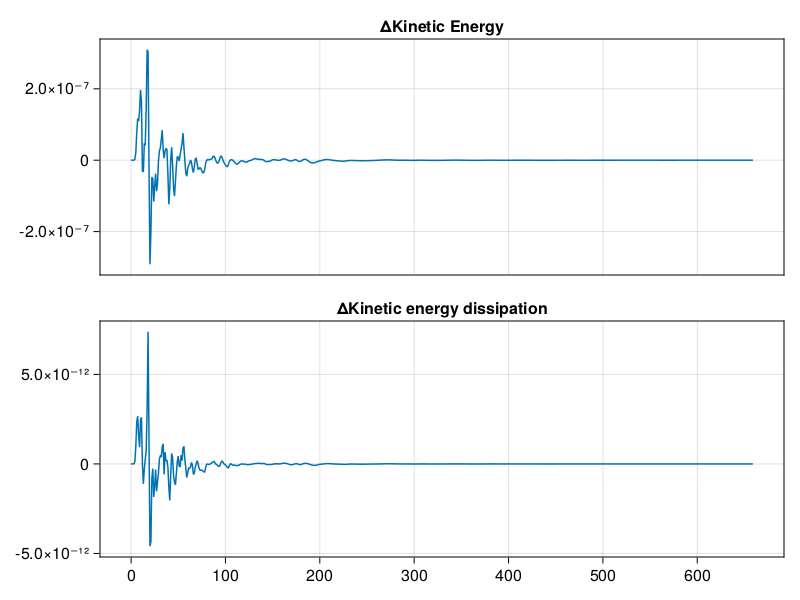

In [19]:
Δ∫Eₖ = diff(∫Eₖ)
Δ∫ϵ = diff(∫ϵ)
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1]) for i ∈ 1:2]
lines!(ax[1], t[1:end-1], Δ∫Eₖ)
ax[1].title = "ΔKinetic Energy"
lines!(ax[2], t[1:end-1], Δ∫ϵ)
ax[2].title = "ΔKinetic energy dissipation"
linkxaxes!(ax[1], ax[2])
hidexdecorations!(ax[1], grid = false)
fig

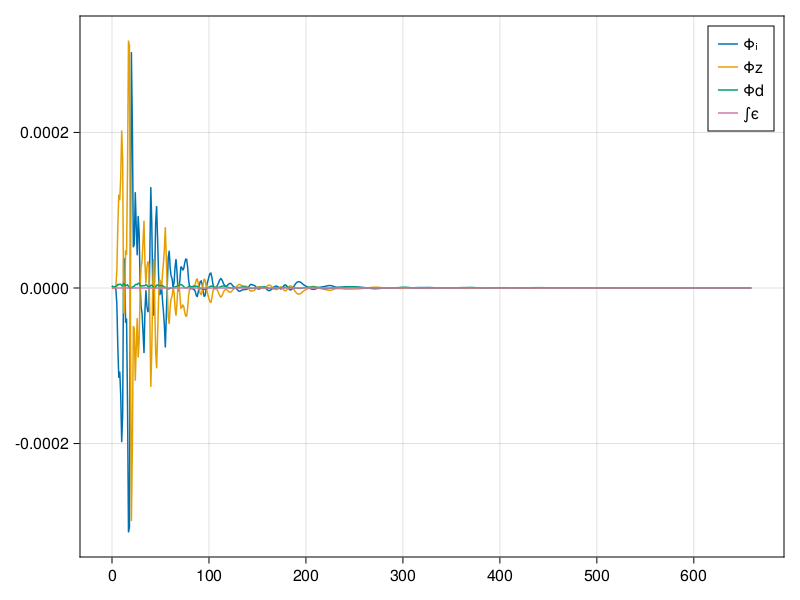

In [82]:
Φz = ρ₀ .* (Δ∫Eₖ .+ Δ∫ϵ)
Δ∫Ep = diff(∫Ep)
Φᵢ = (Δ∫Ep .- Φz)
Φd = diff(∫Eb)
fig, ax = lines(t[1:end-1], Φᵢ, label = "Φᵢ")
lines!(ax, t[1:end-1], Φz, label = "Φz")
lines!(ax, t[1:end-1], Φd, label = "Φd")
lines!(ax, t, ∫ϵ, label = "∫ϵ")
# fig, ax = lines(t[1:end-1], Φᵢ / sum(Φᵢ), label = "Φᵢ")
# lines!(ax, t[1:end-1], Φz / sum(Φz), label = "Φz")
# lines!(ax, t[1:end-1], Φd / sum(Φd), label = "Φd")
# lines!(ax, t, ∫ϵ / sum(∫ϵ), label = "∫ϵ")
axislegend(ax)
fig

## Mixing efficiency

Calculated as in Hughes et al (2009) section 3(a).

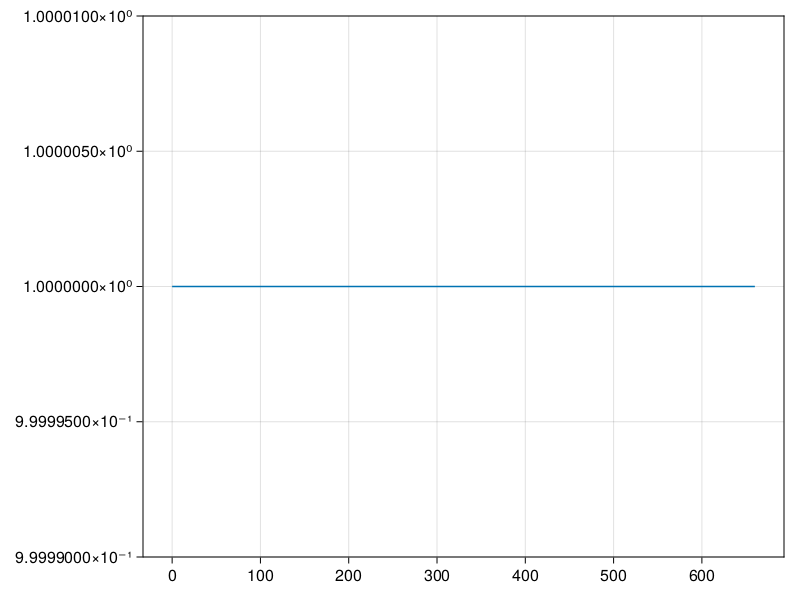

In [86]:
mixing_efficiency = @. (∫Eb) / (∫Eb + ρ₀ .* ∫ϵ) #(∫Eb - Φᵢ_post) / (∫Eb - Φᵢ_post + ∫ϵ)
fig, ax = lines(t, mixing_efficiency)
ylims!(ax, 1-1e-5, 1+1e-5)
fig

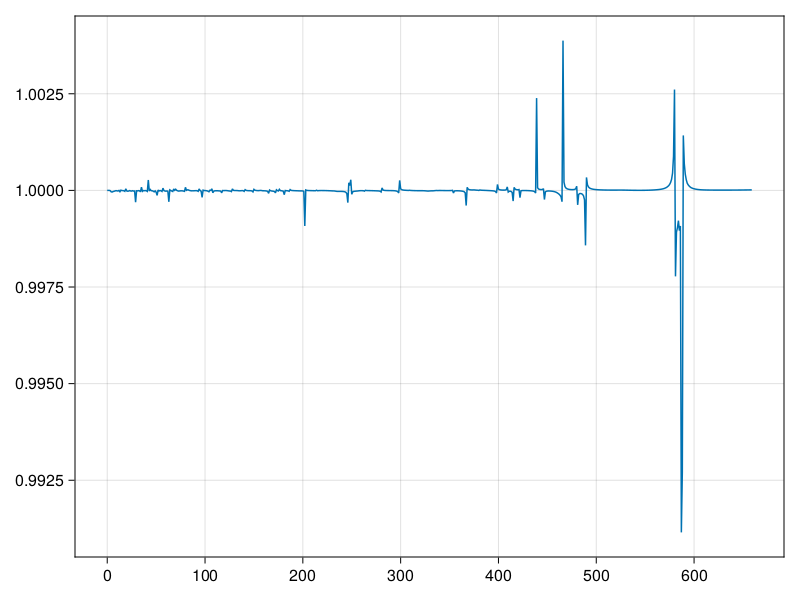

In [85]:
mixing_efficiency = @. (Φd - Φᵢ) / (Φd - Φᵢ + ρ₀ .* Δ∫ϵ)
fig, ax = lines(t[1:end-1], mixing_efficiency)
fig

## Inferred diffusivity calculation check

This is something that it would be great to have but I need to check why the **volume integrated** inferred vertical diffusivity is close to zero.

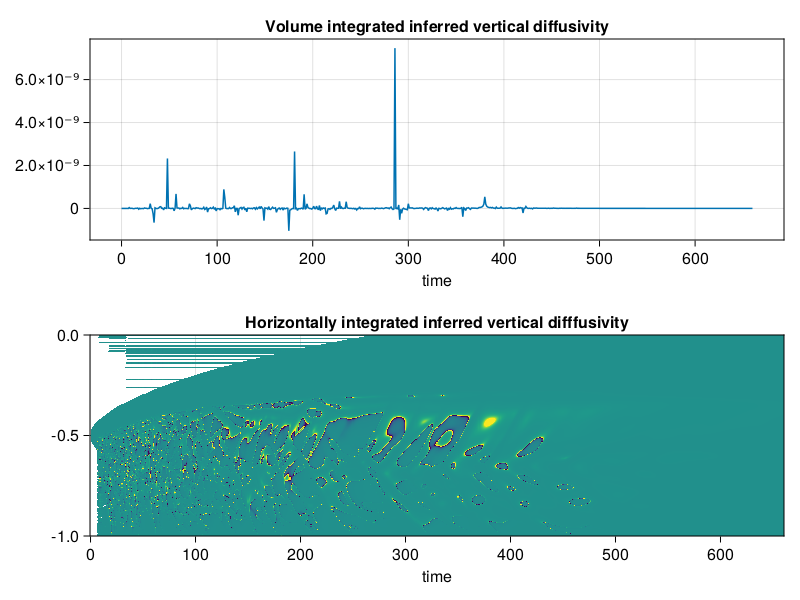

In [174]:
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "time") for i ∈ 1:2]
lines!(ax[1], t, ∫κᵥ, label = "∫κᵥ")
ax[1].title = "Volume integrated inferred vertical diffusivity"
colormap = cgrad(:viridis)[2:end-1]
lowclip = cgrad(:viridis)[1]
highclip = cgrad(:viridis)[end]
colorrange = (-1e-3, 1e-3)
heatmap!(ax[2], t, z_grid, ∫ₐκᵥ'; colormap, colorrange)
ax[2].title = "Horizontally integrated inferred vertical difffusivity"
fig

In [175]:
∫κᵥ

661-element Vector{Float64}:
  0.0
  1.0140458025532227e-19
  9.872390286044152e-19
  1.766752200936479e-17
  3.7466352242631493e-16
  9.453009500365375e-15
  2.1636184196149438e-13
 -4.27885526301278e-12
  3.9312486770385214e-11
  1.8156640893679773e-12
  3.1260438865377576e-12
  7.1314120027759904e-12
 -9.204294222222824e-12
  ⋮
  6.551924498526821e-13
  6.527599656325743e-13
  6.504287394183938e-13
  6.481780431655448e-13
  6.459864334419222e-13
  6.438321224721303e-13
  6.416933558997739e-13
  6.395487876186985e-13
  6.373778417801791e-13
  6.351610522400417e-13
  6.32880370286967e-13
  6.305194325197674e-13

## Checking background potential energy

The background potential energy is

$$
\begin{equation}
E_{b} = \int_{V}g\rho z_{*} \mathrm{d}V
\end{equation}
$$

where $z_{*}$ is the depth as a function of $\rho$ (Winters et al. (1995)).

Calculating this from model data can be done by:

- sorting the the density profile
- using the the sort permutation on a flattened vector for $z$
- numerically integrating over the domain to get an approximation for (1).

This is what I have done to produce the plots above however they are very close to being equal (seemingly up to numerical errors) so I need to check this is producing the correct results.

My code to calculate this is 

```julia
time = ds[:time][:]
g = -9.81
x_length = length(ds[:xC])
y_length = length(ds[:yC])
z = repeat(ds[:zC][:], inner= x_length * y_length)
dV = diff(ds[:xC][1:2]) .* diff(ds[:yC][1:2]) .* diff(ds[:zC][1:2])

∫Eb = similar(time)
for t ∈ eachindex(time)
    σ = reshape(ds[:σ][:, :, :, t], :)
    p = sortperm(σ)
    ∫Eb[t] = g * sum(σ[p] .* z[p] * dV[1])
end
```

I have used the **sorted** density profile to calculate this but looking closely perhaps it should be the in situ density field with $z_{*}$? Looking again at the formulas I think this is the case but will do some checks. I think this is the fix and it makes sense because it is $Z_{*}$ that tells you **where a water parcel needs to be moved to achieve the reference state.**

So I think I just need to change the last line of the loop to

```julia
∫Eb[t] = g * sum(σ .* z[p] * dV[1])
```

Some test calculations below show that this gives non-negligble values for the available potential energy.

In [33]:
σ = reshape(σ, :)
p = sortperm(σ)
g = -9.81
E_b_check = g * sum(σ .* z[p] * dV[1])

50.40884198066249

In [34]:
∫Ep[20]

50.40895751967337

In [35]:
∫Ep[20] - E_b_check

0.00011553901088490193

In [22]:
findmax(∫Eₖ)

(1.5661310718345078e-9, 20)

In [41]:
mean(σ, dims = (1, 2))

1×1×1400 Array{Float64, 3}:
[:, :, 1] =
 1027.7054642152762

[:, :, 2] =
 1027.7054642152966

[:, :, 3] =
 1027.7054642153953

;;; … 

[:, :, 1398] =
 1027.7008428981476

[:, :, 1399] =
 1027.7008428981476

[:, :, 1400] =
 1027.7008428981476

## Inferred diffusivity from changes in reference profile

At each time step there is horizontally averaged profile, a reference profile and a single profile.
I would like to calculate the inferred (vertical) from changes in the horizontally averaged profile to the reference profile.
Perhaps in this case I get the *reference permutation* from the density field, compute the reference temperature then look at how the **reference profile of temperature evoles**.
Based on the plots below this does not look promising.

Maybe it could just be the change in the horizontally averaged profile as time evolves? But the total amount of temperature in the domain does not change except for numerical tracer dissipation.

So inferring the vertical diffusivity must come from the density profile?

Can also try to compute the inferred vertical diffusivity as I did on the fly to check - a good double check.

In [31]:
timestep = 400
tracers_ds = NCDataset(tracers)
Θinitial = tracers_ds[:T][:, : ,:, 1]
Θinitial = reshape(Θinitial, :)
Θ = tracers_ds[:T][:, : ,:, timestep]
Θ = reshape(Θ, :)
#z_grid = tracers_ds[:zC][:]
close(tracers_ds)
co_ds = NCDataset(computed_output)
#t = co_ds[:time][:] ./ 60
σ = co_ds[:σ][:, :, :, timestep]
σ = reshape(σ, :)
p = sortperm(σ)
#x_length = length(co_ds[:xC])
#y_length = length(co_ds[:yC])
#z = repeat(co_ds[:zC][:], inner= x_length * y_length)
#dV = diff(co_ds[:xC][1:2]) .* diff(co_ds[:yC][1:2]) .* diff(co_ds[:zC][1:2])
#z_ref = range(-1, 0, length = length(σ))
close(co_ds)

closed Dataset

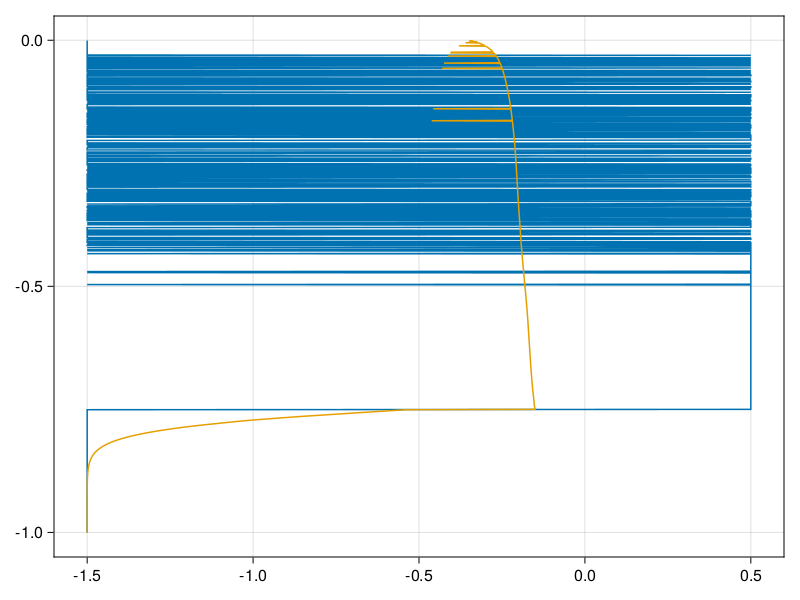

In [32]:
fig, ax  = lines(Θinitial[p][1:x_length * y_length:end], z_ref[1:x_length * y_length:end])
lines!(ax, Θ[p][1:x_length * y_length:end], z_ref[1:x_length * y_length:end])
fig

In [35]:
timestep = 400
tracers_ds = NCDataset(tracers)
Θinitial = mean(tracers_ds[:T][:, : ,:, 1], dims = (1, 2))
Θinitial = reshape(Θinitial, :)
Θ = mean(tracers_ds[:T][:, : ,:, timestep], dims = (1, 2))
Θ = reshape(Θ, :)
z_grid = tracers_ds[:zC][:]
Δz = diff(tracers_ds[:zC][1:2])
close(tracers_ds)

closed Dataset

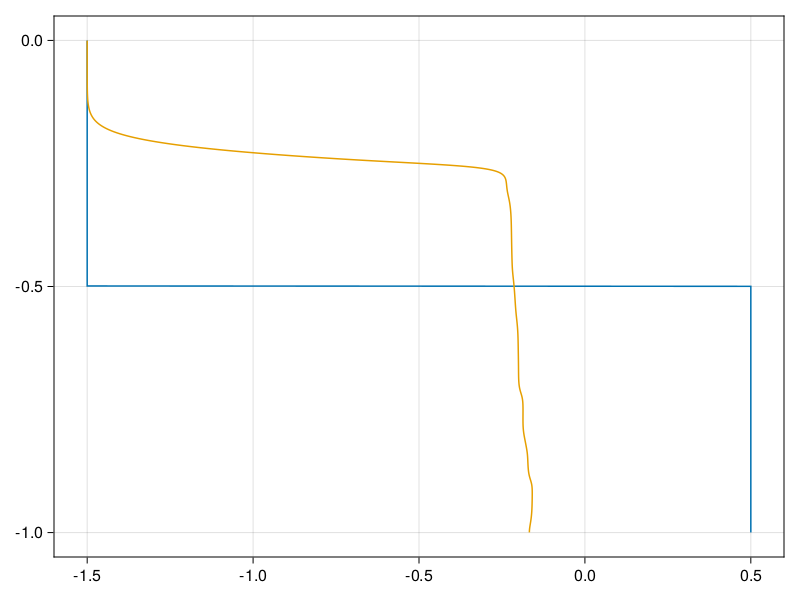

In [36]:
fig, ax  = lines(Θinitial, z_grid)
lines!(ax, Θ, z_grid)
fig

In [47]:
timestep = 400
tracers_ds = NCDataset(tracers)
Θ = mean(tracers_ds[:T][:, : ,:, timestep], dims = (1, 2))
Θ = reshape(Θ, :) .- mean(Θ)
z_grid = tracers_ds[:zC][:]
Δz = diff(tracers_ds[:zC][1:2])
close(tracers_ds)
velocities_ds = NCDataset(velocities)
w = mean(velocities_ds[:w][:, :, :, timestep], dims = (1, 2))
w = reshape(w, :)
close(velocities_ds)

closed Dataset

In [49]:
w .* vcat(Θ[1], Θ) 

1401-element Vector{Float64}:
  0.0
  0.0
  3.7364043768116844e-23
  3.736668754163041e-23
  7.474127747688675e-23
 -7.475176298780873e-23
  0.0
  7.478030975340106e-23
  0.0
  0.0
  0.0
  0.0
 -1.4978524778498352e-22
  ⋮
  8.853605550042517e-25
 -7.488445783479211e-26
 -3.7902310643724385e-24
 -2.3070339393805253e-24
 -4.739054912106376e-24
 -6.5982905999967455e-24
 -8.129327644731859e-24
 -6.615206988786094e-24
 -5.975833787033232e-24
 -3.3935186107880615e-24
 -1.2269064585795252e-25
 -0.0

In [51]:
diff(vcat(Θ[1], Θ))

1400-element Vector{Float64}:
  0.0
  1.1744544020531045e-5
  2.3433510935644275e-5
  3.5022067227163944e-5
  4.647000463442463e-5
  5.773672872949609e-5
  6.877769095359199e-5
  7.954243393504257e-5
  8.997423966605744e-5
  0.00010001120294045318
  0.00010958842045438733
  0.0001186409036686431
  0.00012710679639216238
  ⋮
 -7.762556819557176e-9
 -6.999017809761199e-9
 -6.2667386835357775e-9
 -5.5625011263771285e-9
 -4.883191628834993e-9
 -4.225797933798958e-9
 -3.5873948256437416e-9
 -2.9651312516421058e-9
 -2.356220107913032e-9
 -1.7579280253698926e-9
 -1.1675642674902065e-9
 -5.824674076393421e-10